# Projet numérique de science des données - BEUZELIN  Tristan et LEBOEUF  Antoine

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrés de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Préliminaires

In [7]:
import matplotlib.pyplot as plt
from sklearn import preprocessing, neighbors, metrics, model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

score_modele = {} # Dictionnaire avec les scores des différents modèles

### Chargement des données étiquetées

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')
df_private = pd.read_csv('data/foret_prive.tsv', delimiter='\t')

In [10]:
df_public.head()
df_private.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu
0,2654,42,15,60,7,1862,221,206,116,6907
1,2649,24,13,30,2,1832,213,211,133,6889
2,2647,357,16,0,0,1802,194,210,152,6870
3,2650,5,19,0,0,1772,192,199,141,6852
4,2645,25,24,30,7,1742,201,182,108,6834


### Extraction de la matrice de design et des étiquettes 

In [11]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])

### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 0.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

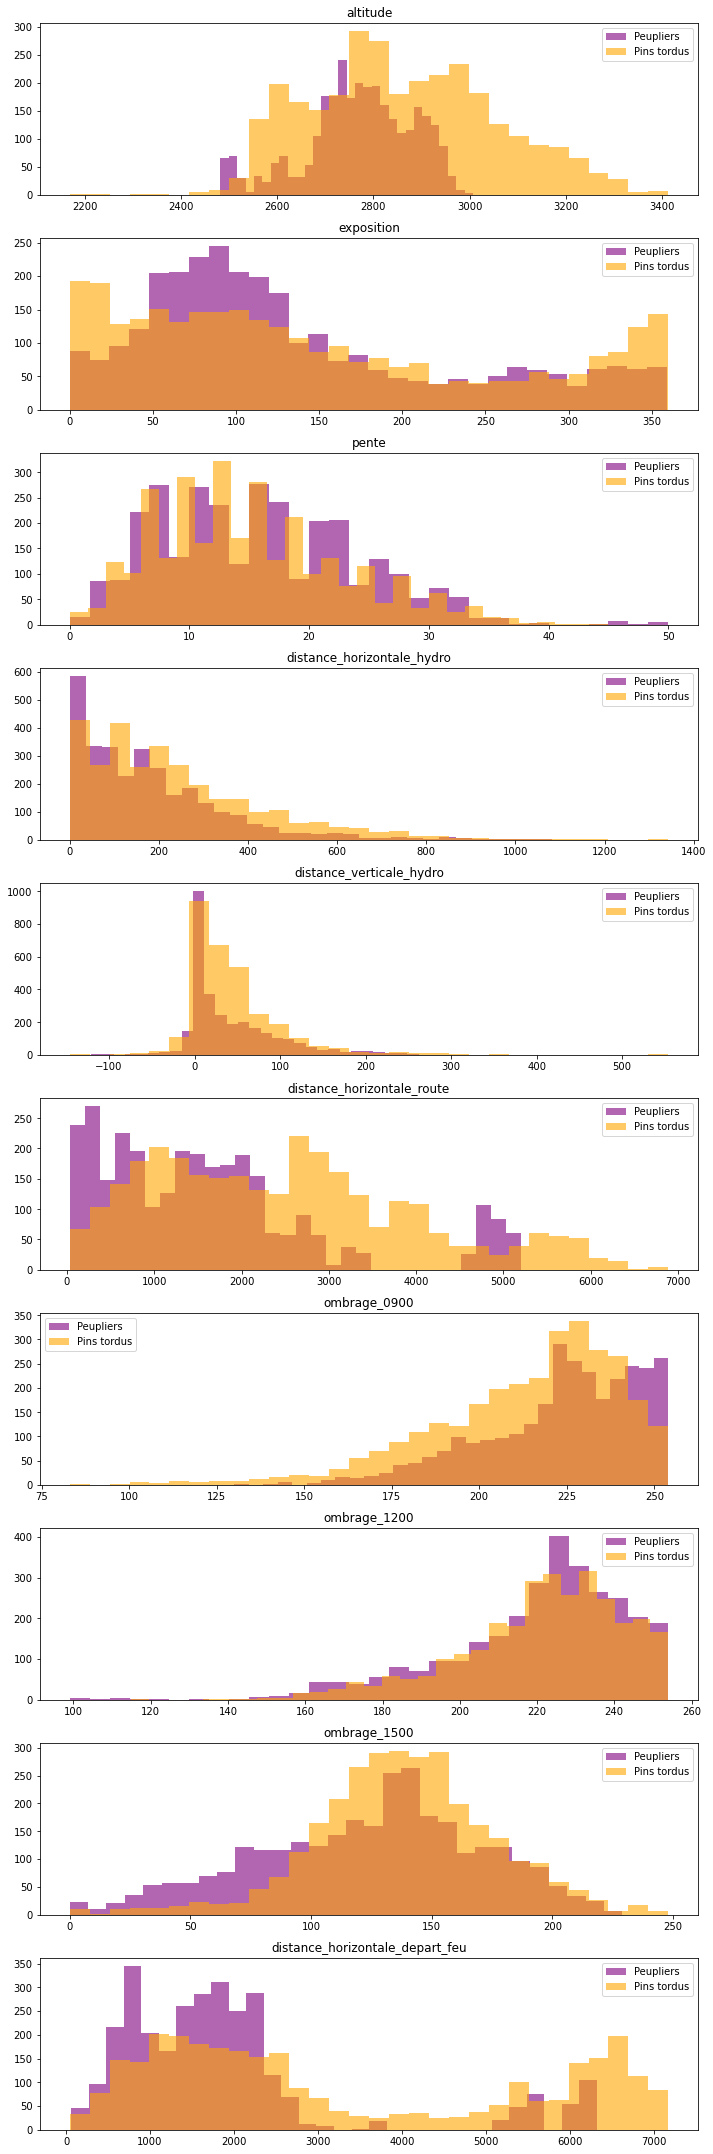

In [12]:
pos_indices = np.where(y_public==1)[0]
neg_indices = np.where(y_public==0)[0]

fig = plt.figure(figsize=(10, 30))

for (idx_feature, n_feature) in enumerate(df_public.drop(columns=['espece'])):
    
    # create a subplot in the (plot_idx+1) position of a 6x2 grid
    ax = fig.add_subplot(10, 1, (idx_feature+1))
    # plot the histogram of feat_idx
    h_pos = ax.hist(X_public[pos_indices, idx_feature], bins=30, edgecolor='none', alpha=0.6, label='Peupliers', color='purple')
    h_neg = ax.hist(X_public[neg_indices, idx_feature], bins=30, edgecolor='none', alpha=0.6, label='Pins tordus', color='orange')
    ax.legend()
    # use the name of the feature as a title for each histogram
    ax.set_title(n_feature)
    
# espacement entre les subplots
fig.tight_layout(pad=1.)

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

On remarque sur les différents histogrammes que les deux espèces d'arbres vivent dans des envirronements similaires. En effet, à l'oeil nu on peut difficilement distinguer un trait caractéristique pour les différencier. Ainsi, la création d'un modèle prédicitif semble justifié.

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. Justifiez vos choix. Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

Pour certaines variables, la distribution des observations ne semble pas normale. C'est pourquoi nous choisissons d'appliquer la transformation de Yeo-Johnson permettant de rapprocher les variables de gaussiennes même s'il y a des valeurs négatives (contrairement à la méthode Box-Cox).
Par ailleurs, on normalise toutes les variables pour pouvoir les comparer entre elles.

In [13]:
yeojohnson_scaler = preprocessing.PowerTransformer(method='yeo-johnson')
yeojohnson_scaler.fit(X_public)

PowerTransformer()

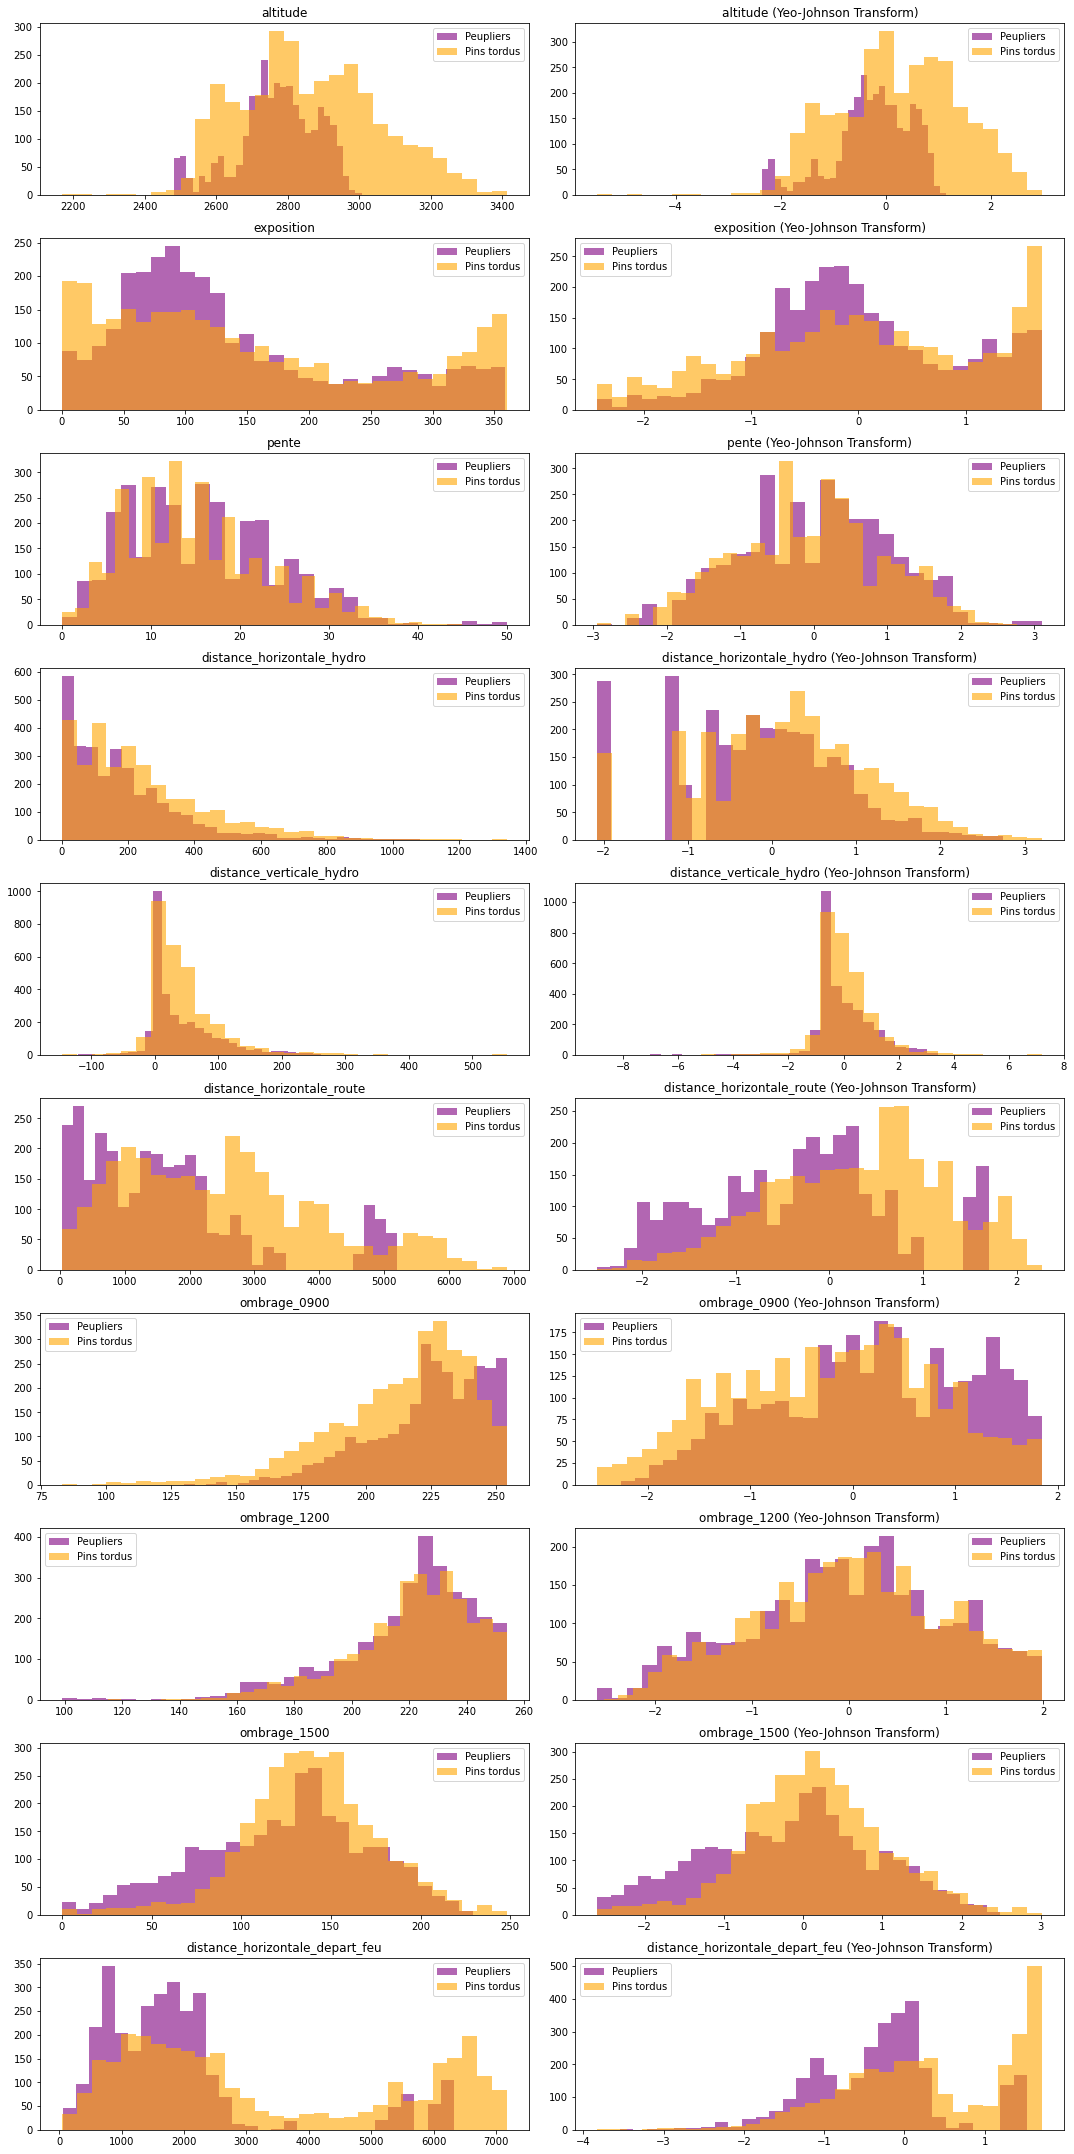

In [14]:
X_public_preprocessed = yeojohnson_scaler.transform(X_public)

pos_indices = np.where(y_public==1)[0]
neg_indices = np.where(y_public==0)[0]

fig = plt.figure(figsize=(15, 30))

for (idx_feature, n_feature) in enumerate(df_public.drop(columns=['espece'])):
    
    # create a subplot in the (plot_idx+1) position of a 10x2 grid
    ax = fig.add_subplot(10, 2, (2*idx_feature+1))
    # plot the histogram of feat_idx
    h_pos = ax.hist(X_public[pos_indices, idx_feature], bins=30, edgecolor='none', alpha=0.6, label='Peupliers', color='purple')
    h_neg = ax.hist(X_public[neg_indices, idx_feature], bins=30, edgecolor='none', alpha=0.6, label='Pins tordus', color='orange')
    ax.legend()
    # use the name of the feature as a title for each histogram
    ax.set_title(n_feature)
    
for (idx_feature, n_feature) in enumerate(df_public.drop(columns=['espece'])):
    
    # create a subplot in the (plot_idx+1) position of a 10x2 grid
    ax = fig.add_subplot(10, 2, (2*idx_feature+2))
    # plot the histogram of feat_idx
    h_pos_yeo = ax.hist(X_public_preprocessed[pos_indices, idx_feature], bins=30, edgecolor='none', alpha=0.6, label='Peupliers', color='purple')
    h_neg_yeo = ax.hist(X_public_preprocessed[neg_indices, idx_feature], bins=30, edgecolor='none', alpha=0.6, label='Pins tordus', color='orange')
    ax.legend()
    # use the name of the feature as a title for each histogram
    ax.set_title(n_feature + ' (Yeo-Johnson Transform)')
    
# espacement entre les subplots
fig.tight_layout(pad=1.)

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle des sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [15]:
predictor_5NN = neighbors.KNeighborsClassifier(n_neighbors=5)
predictor_5NN.fit(X_public_preprocessed, y_public)

KNeighborsClassifier()

### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

D'après la définition : $F = 2 \, \frac{precision \, \times \, recall}{precision \, + \, recall}$

Si notre modèle était naïf et prédisait systématiquement la classe positive, alors on aurait $recall = 1$ car tous les cas positifs réels seraient détectés. Par contre, $precision = \frac{{nb}_{positifs}^{réels}}{{nb}_{total}}$, ce qui dépend des effectifs du jeu de données. Dans notre cas :

In [16]:
print("Nb de peupliers : ", X_public[pos_indices].shape[0])
print("Nb de pins tordus : ", X_public[neg_indices].shape[0])

Nb de peupliers :  3000
Nb de pins tordus :  3000


Sur le jeu d'entraînement, nous trouvons autant de peupliers que de pins tordus. La précision est donc égale à $\frac{1}{2}$. Nous trouvons ainsi finalement un F score égal à $\frac{2}{3}$. 

#### Question 6

Quel est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

In [17]:
y_pred = predictor_5NN.predict(X_public_preprocessed)
F_score = metrics.f1_score(y_public, y_pred)
print(f'F score : {F_score}')

F score : 0.9276089000313382


#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

Cette performance ne parait finalement pas surprenante. En théorie, le score obtenu est largement satisfaisant (le score maximal étant, pour un modèle parfait, de 1). Cependant, nous testons notre modèle de plus proches voisins sur le même jeu de données ayant servi à l'entraînement. Par conséquent, le modèle est très adapté à cet échantillon en particulier mais l'on ne peut évaluer sa capacité à se généraliser et s'adapter à d'autres échantillons.

## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [18]:
# Use 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_public_preprocessed, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=42) 
print(X_train.shape, X_test.shape)

(4800, 10) (1200, 10)


### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [19]:
predictor_5NN = neighbors.KNeighborsClassifier(n_neighbors=5)
predictor_5NN.fit(X_train, y_train)

KNeighborsClassifier()

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [20]:
y_pred = predictor_5NN.predict(X_test)
F_score = metrics.f1_score(y_test, y_pred)
print(f'F score : {F_score}')

score_modele['5NN'] = F_score

F score : 0.9008455034588778


#### Question 9
Commentez le F-score obtenu ci-dessus.

Le F-score obtenu est largement satisfaisant, d'autant plus qu'il a été évalué sur un jeu de test indépendant de celui d'entraînement. Cela nous en apprend plus sur la capacité de généralisation de notre modèle de plus proches voisins.

## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [21]:
predictor_kNN = neighbors.KNeighborsClassifier()
k_list = np.arange(1, 21, 1)
tuned_parameters = [{'n_neighbors': k_list}]

nb_folds = 5
grid = GridSearchCV(predictor_kNN, tuned_parameters, cv=nb_folds, refit=True, verbose = 3, scoring='f1')

grid.fit(X_train, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']
std_error = scores_std / np.sqrt(nb_folds)

grid.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.888 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.909 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.895 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.884 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.909 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.889 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.887 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.897 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.867 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.898 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.890 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3

KNeighborsClassifier(n_neighbors=1)

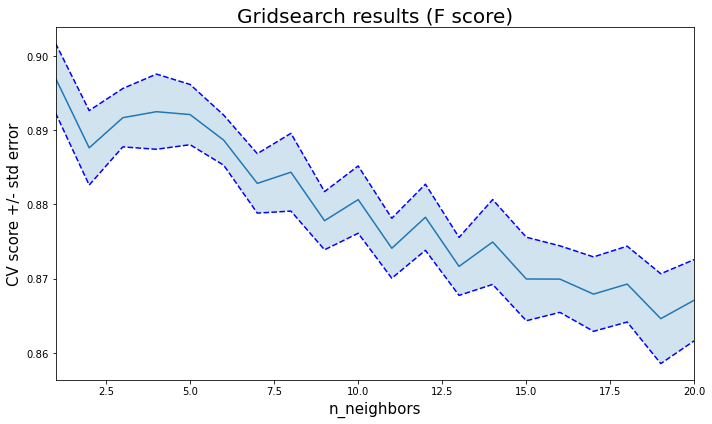

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(k_list, scores)
plt.plot(k_list, scores + std_error, 'b--')
plt.plot(k_list, scores - std_error, 'b--')

plt.fill_between(k_list, scores + std_error, scores - std_error, alpha=0.2)

plt.xlabel("n_neighbors", fontsize=15)
plt.ylabel("CV score +/- std error", fontsize=15)
plt.xlim([k_list[0], k_list[-1]])
plt.title("Gridsearch results (F score)", fontsize=20)
plt.tight_layout()
plt.show()

#### Question 10.b
Quel est le F-score correspondant au nombre de voisin optimal ?

In [23]:
print('F-score du nombre de voisins optimal : {:.3f}'.format(grid.best_score_))

F-score du nombre de voisins optimal : 0.897


#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [24]:
y_pred = grid.best_estimator_.predict(X_test)
F_score = metrics.f1_score(y_test, y_pred)
print(f'F score : {F_score}')
score_modele['1NN'] = F_score

F score : 0.9102362204724409


Nous obtenons un F-score un peu meilleur que celui en effectuant un 5NN sans cross-validation. Par ailleurs, le modèle obtenu est relativement robuste puisqu'il est passé par un process de train-test en cross validation.

## [À partir de la PC 5] Régression logistique

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [25]:
predictor_logistic = LogisticRegression(penalty='none')
predictor_logistic.fit(X_train, y_train)

LogisticRegression(penalty='none')

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

F score : 0.7391304347826088
Coefs : [[-0.74179485  0.24679726 -0.12904693 -0.40946436  0.17875866 -0.29106828
   0.02551873  0.45279619 -0.65735514 -0.93027507]]


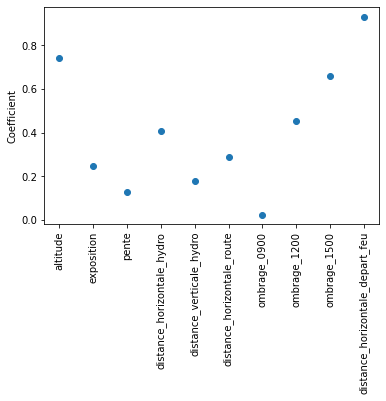

In [26]:
y_pred = predictor_logistic.predict(X_test)
F_score = metrics.f1_score(y_test, y_pred)
print(f'F score : {F_score}')
print(f'Coefs : {predictor_logistic.coef_}')
score_modele['reglog_noreg'] = F_score

# Affichage coefficients du modèle
num_features = X_train.shape[1]
feature_names = df_public.drop(columns=['espece']).columns
plt.scatter(range(num_features), np.abs(predictor_logistic.coef_))

tmp = plt.xticks(range(num_features), feature_names, rotation=90)
tmp = plt.ylabel('Coefficient')

Nous remarquons qu'avec cette méthode le F-score obtenu est assez peu satisfaisant.

#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

On s'attend à ce que la régularisation l2 n'améliore que très faiblement les performances de notre modèle car elle limite l'obtention de valeurs extrêmes pour les poids des variables dans le modèle linéaire. Mais comme vu ci-dessus, les coefficients que nous obtenons se trouvent dans une gamme de valeurs assez restreinte (moins d'un facteur 10 entre les coefs extrêmes) donc l'effet ne sera pas très prononcé.

D'ailleurs, la régularisation est censée limiter le surapprentissage, mais ici nous ne nous trouvons pas dans cette situation.

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [27]:
predictor_logistic = LogisticRegression(penalty = 'l2')
reg_list = [1/(i+1) for i in range(100)]
tuned_parameters = [{'C': reg_list}]

nb_folds = 5
grid = GridSearchCV(predictor_logistic, tuned_parameters, cv=nb_folds, refit=True, verbose = 3, scoring='f1')

grid.fit(X_train, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']
std_error = scores_std / np.sqrt(nb_folds)

grid.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .............................C=1.0;, score=0.749 total time=   0.0s
[CV 2/5] END .............................C=1.0;, score=0.743 total time=   0.0s
[CV 3/5] END .............................C=1.0;, score=0.735 total time=   0.0s
[CV 4/5] END .............................C=1.0;, score=0.750 total time=   0.0s
[CV 5/5] END .............................C=1.0;, score=0.749 total time=   0.0s
[CV 1/5] END .............................C=0.5;, score=0.748 total time=   0.0s
[CV 2/5] END .............................C=0.5;, score=0.744 total time=   0.0s
[CV 3/5] END .............................C=0.5;, score=0.735 total time=   0.0s
[CV 4/5] END .............................C=0.5;, score=0.750 total time=   0.0s
[CV 5/5] END .............................C=0.5;, score=0.749 total time=   0.0s
[CV 1/5] END ..............C=0.3333333333333333;, score=0.748 total time=   0.0s
[CV 2/5] END ..............C=0.333333333333333

[CV 4/5] END ............C=0.047619047619047616;, score=0.747 total time=   0.0s
[CV 5/5] END ............C=0.047619047619047616;, score=0.751 total time=   0.0s
[CV 1/5] END ............C=0.045454545454545456;, score=0.748 total time=   0.0s
[CV 2/5] END ............C=0.045454545454545456;, score=0.741 total time=   0.0s
[CV 3/5] END ............C=0.045454545454545456;, score=0.742 total time=   0.0s
[CV 4/5] END ............C=0.045454545454545456;, score=0.747 total time=   0.0s
[CV 5/5] END ............C=0.045454545454545456;, score=0.751 total time=   0.0s
[CV 1/5] END ............C=0.043478260869565216;, score=0.746 total time=   0.0s
[CV 2/5] END ............C=0.043478260869565216;, score=0.741 total time=   0.0s
[CV 3/5] END ............C=0.043478260869565216;, score=0.742 total time=   0.0s
[CV 4/5] END ............C=0.043478260869565216;, score=0.747 total time=   0.0s
[CV 5/5] END ............C=0.043478260869565216;, score=0.751 total time=   0.0s
[CV 1/5] END ............C=0

[CV 5/5] END ............C=0.024390243902439025;, score=0.747 total time=   0.0s
[CV 1/5] END ............C=0.023809523809523808;, score=0.746 total time=   0.0s
[CV 2/5] END ............C=0.023809523809523808;, score=0.740 total time=   0.0s
[CV 3/5] END ............C=0.023809523809523808;, score=0.742 total time=   0.0s
[CV 4/5] END ............C=0.023809523809523808;, score=0.745 total time=   0.0s
[CV 5/5] END ............C=0.023809523809523808;, score=0.747 total time=   0.0s
[CV 1/5] END ............C=0.023255813953488372;, score=0.746 total time=   0.0s
[CV 2/5] END ............C=0.023255813953488372;, score=0.740 total time=   0.0s
[CV 3/5] END ............C=0.023255813953488372;, score=0.742 total time=   0.0s
[CV 4/5] END ............C=0.023255813953488372;, score=0.745 total time=   0.0s
[CV 5/5] END ............C=0.023255813953488372;, score=0.748 total time=   0.0s
[CV 1/5] END ............C=0.022727272727272728;, score=0.746 total time=   0.0s
[CV 2/5] END ............C=0

[CV 5/5] END ............C=0.016129032258064516;, score=0.748 total time=   0.0s
[CV 1/5] END ............C=0.015873015873015872;, score=0.749 total time=   0.0s
[CV 2/5] END ............C=0.015873015873015872;, score=0.742 total time=   0.0s
[CV 3/5] END ............C=0.015873015873015872;, score=0.742 total time=   0.0s
[CV 4/5] END ............C=0.015873015873015872;, score=0.743 total time=   0.0s
[CV 5/5] END ............C=0.015873015873015872;, score=0.748 total time=   0.0s
[CV 1/5] END ........................C=0.015625;, score=0.749 total time=   0.0s
[CV 2/5] END ........................C=0.015625;, score=0.742 total time=   0.0s
[CV 3/5] END ........................C=0.015625;, score=0.744 total time=   0.0s
[CV 4/5] END ........................C=0.015625;, score=0.743 total time=   0.0s
[CV 5/5] END ........................C=0.015625;, score=0.747 total time=   0.0s
[CV 1/5] END ............C=0.015384615384615385;, score=0.749 total time=   0.0s
[CV 2/5] END ............C=0

[CV 4/5] END ............C=0.012048192771084338;, score=0.742 total time=   0.0s
[CV 5/5] END ............C=0.012048192771084338;, score=0.748 total time=   0.0s
[CV 1/5] END ............C=0.011904761904761904;, score=0.748 total time=   0.0s
[CV 2/5] END ............C=0.011904761904761904;, score=0.738 total time=   0.0s
[CV 3/5] END ............C=0.011904761904761904;, score=0.743 total time=   0.0s
[CV 4/5] END ............C=0.011904761904761904;, score=0.741 total time=   0.0s
[CV 5/5] END ............C=0.011904761904761904;, score=0.748 total time=   0.0s
[CV 1/5] END ............C=0.011764705882352941;, score=0.746 total time=   0.0s
[CV 2/5] END ............C=0.011764705882352941;, score=0.738 total time=   0.0s
[CV 3/5] END ............C=0.011764705882352941;, score=0.743 total time=   0.0s
[CV 4/5] END ............C=0.011764705882352941;, score=0.741 total time=   0.0s
[CV 5/5] END ............C=0.011764705882352941;, score=0.748 total time=   0.0s
[CV 1/5] END ............C=0

LogisticRegression(C=0.06666666666666667)

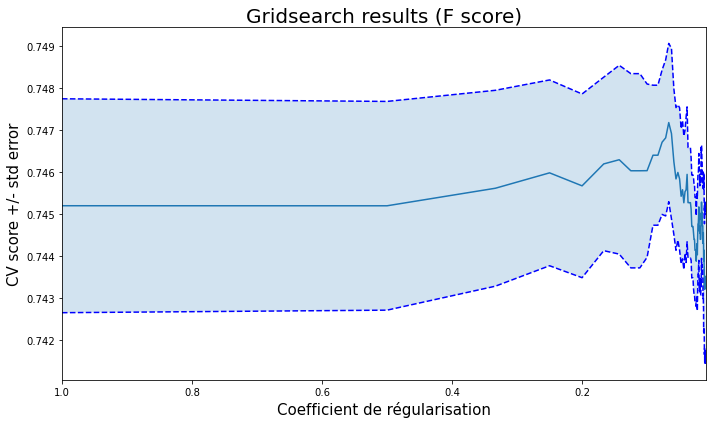

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(reg_list, scores)
plt.plot(reg_list, scores + std_error, 'b--')
plt.plot(reg_list, scores - std_error, 'b--')

plt.fill_between(reg_list, scores + std_error, scores - std_error, alpha=0.2)

plt.xlabel("Coefficient de régularisation", fontsize=15)
plt.ylabel("CV score +/- std error", fontsize=15)
plt.xlim([reg_list[0], reg_list[-1]])
plt.title("Gridsearch results (F score)", fontsize=20)
plt.tight_layout()
plt.show()

#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [29]:
y_pred = grid.best_estimator_.predict(X_test)
F_score = metrics.f1_score(y_test, y_pred)
print(f'F score : {F_score}')
score_modele['reglog_yesreg'] = F_score

F score : 0.7330543933054394


#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

Ce F-score est légèrement moins bon que le précédent à la question 12. Il reste peu satisfaisant car son efficacité était limitée dans notre cas au vu de la relative uniformité des coefficents obtenus auparavant (pas de valeurs extrêmes).

#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

In [30]:
predictor_forest = RandomForestClassifier()
nb_trees = np.arange(10, 200, 10)
tuned_parameters = [{'n_estimators': nb_trees}]

nb_folds = 5
grid = GridSearchCV(predictor_forest, tuned_parameters, cv=nb_folds, refit=True, verbose = 3, scoring='f1')

grid.fit(X_train, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']
std_error = scores_std / np.sqrt(nb_folds)

grid.best_estimator_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5] END ...................n_estimators=10;, score=0.917 total time=   0.0s
[CV 2/5] END ...................n_estimators=10;, score=0.928 total time=   0.0s
[CV 3/5] END ...................n_estimators=10;, score=0.910 total time=   0.0s
[CV 4/5] END ...................n_estimators=10;, score=0.913 total time=   0.0s
[CV 5/5] END ...................n_estimators=10;, score=0.916 total time=   0.0s
[CV 1/5] END ...................n_estimators=20;, score=0.929 total time=   0.1s
[CV 2/5] END ...................n_estimators=20;, score=0.931 total time=   0.1s
[CV 3/5] END ...................n_estimators=20;, score=0.922 total time=   0.1s
[CV 4/5] END ...................n_estimators=20;, score=0.918 total time=   0.1s
[CV 5/5] END ...................n_estimators=20;, score=0.932 total time=   0.1s
[CV 1/5] END ...................n_estimators=30;, score=0.933 total time=   0.2s
[CV 2/5] END ...................n_estimators=30;

RandomForestClassifier(n_estimators=170)

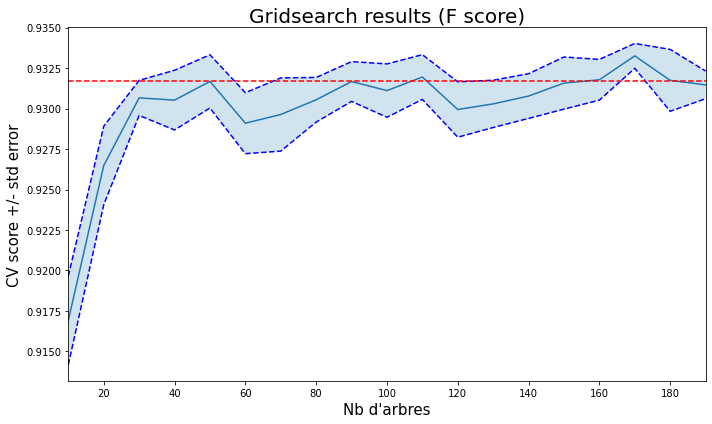

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(nb_trees, scores)
plt.plot(nb_trees, scores + std_error, 'b--')
plt.plot(nb_trees, scores - std_error, 'b--')
plt.axhline(y=scores[8], c='r', ls='--')

plt.fill_between(nb_trees, scores + std_error, scores - std_error, alpha=0.2)

plt.xlabel("Nb d'arbres", fontsize=15)
plt.ylabel("CV score +/- std error", fontsize=15)
plt.xlim([nb_trees[0], nb_trees[-1]])
plt.title("Gridsearch results (F score)", fontsize=20)
plt.tight_layout()
plt.show()

D'après ce graphique, la performance du modèle semble plafonner avec le nombre d'arbres. Ainsi, ce n'est pas parce qu'on a plus d'arbres que le modèle est plus précis d'autant plus d'une grande forêt met plus de temps à s'exécuter.

En raison de ce compromis entre le score et ressource, on choisira une forêt avec 90 arbres même s'il est possible d'avoir un résultat légèrement supérieur avec une forêt plus grande mais plus coûteuse.

In [32]:
y_pred = grid.best_estimator_.predict(X_test)
F_score = metrics.f1_score(y_test, y_pred)
print(f'F score : {F_score}')
score_modele['Forest'] = F_score

F score : 0.9426957223567393


## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

Nous n'avons utilisé qu'un prétraitement, celui de Yeo-Johnson.

Voici la liste des modèles utilisés :
- 5 plus proches voisins (5NN)
- 1 plus proche voisin
- Régression logistique non régularisée
- Régression logistique régularisée
- Forêt aléatoire

(0.6, 1.0)

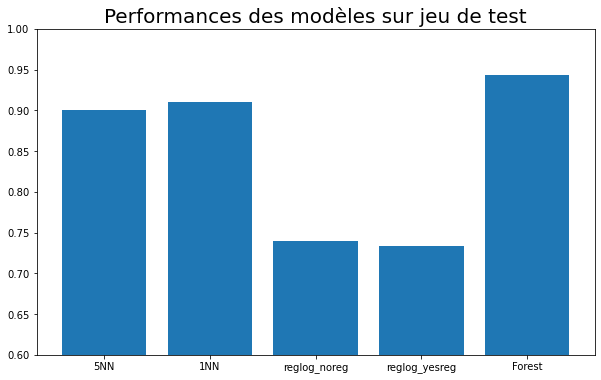

In [33]:
plt.figure(figsize = (10, 6))
plt.title('Performances des modèles sur jeu de test', fontsize=20)
plt.bar(range(len(score_modele.values())), score_modele.values(), tick_label=list(score_modele.keys()))
plt.ylim((0.6, 1.0))

#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

Notre méthode d'évalutation ne se base que sur le F-score de chaque modèle sur le jeu de test. Le pré-traitement choisi est celui de Yeo-Johnson. L'algorithme optimal est, comme vu ci-dessus, celui de la forêt d'arbres aléatoire, avec 260 arbres. Cependant, notre évalutation ne prend en compte que les performances sur le jeu de test, qui varie à chaque execution du code. Il aurait également été judicieux de prendre en compte les performances moyennes sur les K-fold des processus de cross validation.

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

In [34]:
X_private = np.array(df_private)

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

In [35]:
yeojohnson_scaler = preprocessing.PowerTransformer(method='yeo-johnson')
yeojohnson_scaler.fit(X_public)
X_public_preprocessed = yeojohnson_scaler.transform(X_public)

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

In [36]:
yeojohnson_scaler = preprocessing.PowerTransformer(method='yeo-johnson')
yeojohnson_scaler.fit(X_private)
X_private_preprocessed = yeojohnson_scaler.transform(X_private)

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

In [37]:
predictor_forest = RandomForestClassifier(n_estimators=90)
predictor_forest.fit(X_public_preprocessed, y_public)

RandomForestClassifier(n_estimators=90)

#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

In [38]:
y_pred_final = predictor_forest.predict(X_private_preprocessed)

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [39]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.